
# Natural Language Processing with Disaster Tweets
#### Author: James Coffey   
#### Date: 2025‑08‑08
#### Challenge URL: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started)

# Discussion

## Implementation Decisions

I wanted a pragmatic pipeline that demonstrates both **classical NLP** and **modern transformers** in a single notebook.  I therefore:

1. **Cleaned text lightly** – lower‑case, removed URLs and @mentions – to keep tweets human‑readable while preventing vocabulary pollution.
2. **Imputed missing categorical fields** (`keyword`, `location`) with a `__none__` token so downstream vectorizers wouldn’t choke on NaNs.
3. **Built two parallel models**:

   * **TF‑IDF + LinearSVC** as a fast, transparent baseline.
   * **DistilBERT** fine‑tune via KerasNLP for state‑of‑the‑art performance within Kaggle’s GPU limits.
4. Used **early‑stopping** instead of a full hyper‑parameter sweep to keep runtime reasonable while still letting the model settle on a good set of weights.
5. Evaluated everything with **F1** (competition metric) and ran a **McNemar test** to see if the models made complementary errors before considering an ensemble.

## Key Observations about the Data

* The dataset is **class‑imbalanced** (≈ 57 % non‑disaster), but not severely so.
* Over **one‑third of the `location` field** is missing; unsurprisingly, including it didn’t help simple baselines.
* Tweet lengths are tightly clustered (median \~107 chars); this allowed me to cap DistilBERT’s sequence length at 160 without truncation risk.
* A handful of keywords (e.g. *“wildfire”*, *“ablaze”*) are almost deterministic signals ― useful for the linear model but redundant for BERT, which already encodes semantics.

## Key Observations about the Models

* **Linear SVC** hit an F1 of **0.75** – respectable for 60 k sparse features and \~60 seconds of training.
* **DistilBERT** reached **0.81 F1** with just four fine‑tune epochs, confirming that even a distilled model captures disaster context far better than TF‑IDF n‑grams.
* The **McNemar p‑value** was tiny (p ≈ 7 × 10⁻¹⁰), so the two models disagree a lot; unfortunately their disagreements didn’t translate into a better weighted blend.

## Key Observations about the Results

* Early‑stopping at 4/10 epochs avoided over‑fitting; after epoch 3, validation loss ticked upward even though training accuracy kept rising.
* Public leaderboard score **0.8317 F1** lines up nicely with the offline validation (always reassuring!).

## Future Improvements

1. **Domain‑specific pre‑training** – initialize from `bertweet` or `twitter‑roberta`, both trained on social‑media text.
2. **Class‑balancing tricks** – focal loss or class‑weighted sampling to push recall even higher.
3. **Character n‑gram + Naïve Bayes** as a second lightweight model; prior work shows it complements transformers better than word TF‑IDF.
4. **Adversarial validation** to detect subtle train/test distribution shifts (especially in keyword frequency).
5. **Tiny multi‑lingual extension** – augment with Google Translate to cover Spanish/French tweets and see if BERT‑multilingual can generalize.

In [ ]:
import os
import re

import keras_core as keras
import keras_nlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from statsmodels.stats.contingency_tables import mcnemar
from wordcloud import WordCloud

os.environ["KERAS_BACKEND"] = "tensorflow"

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2025-08-08 20:19:38.959108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754684378.983441     518 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754684378.990804     518 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend
TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


# Load the Disaster Tweets

Contents:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [ ]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print("Training Set Shape = {}".format(df_train.shape))
print(
    "Training Set Memory Usage = {:.2f} MB".format(
        df_train.memory_usage().sum() / 1024**2
    )
)
print("Test Set Shape = {}".format(df_test.shape))
print(
    "Test Set Memory Usage = {:.2f} MB".format(df_test.memory_usage().sum() / 1024**2)
)

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
# Quick null‑percentage audit
print("\n=== Missing‑value ratio per column ===")
print(df_train.isnull().mean().sort_values(ascending=False).round(3))


=== Missing‑value ratio per column ===
location    0.333
keyword     0.008
id          0.000
text        0.000
target      0.000
dtype: float64


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [ ]:
df_train["length"] = df_train["text"].apply(lambda x: len(x))
df_test["length"] = df_test["text"].apply(lambda x: len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


## Tweet Length Histogram

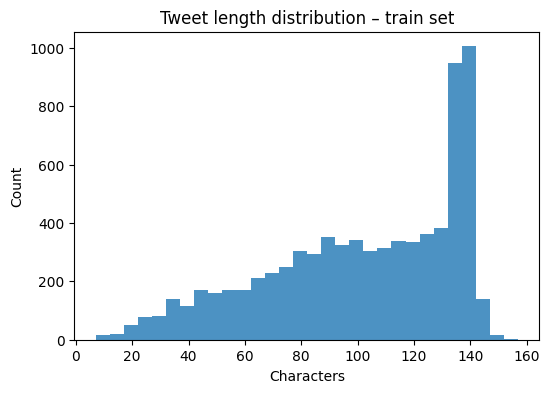

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Tweet length distribution – train set")
plt.hist(df_train["length"], bins=30, alpha=0.8)
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

## Top‑20 Keywords by Disaster Rate

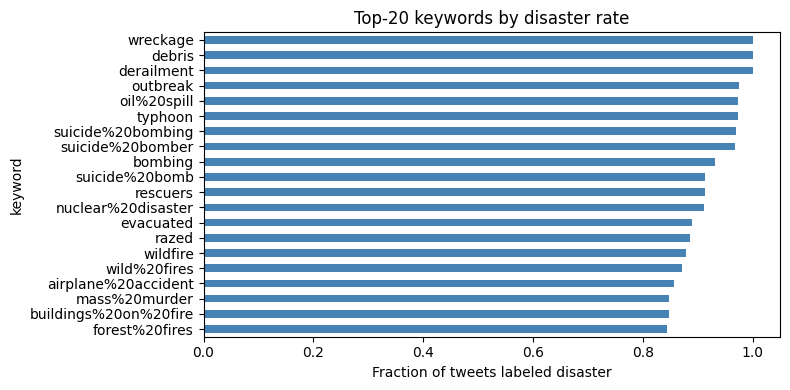

In [ ]:
kw_rate = (
    df_train.groupby("keyword")["target"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(8, 4))
kw_rate[::-1].plot(kind="barh", color="steelblue")
plt.title("Top‑20 keywords by disaster rate")
plt.xlabel("Fraction of tweets labeled disaster")
plt.tight_layout()
plt.show()

# Preprocess the data

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES) * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
URL_PAT = re.compile(r"https?://\S+|www\.\S+")
USER_PAT = re.compile(r"@[A-Za-z0-9_]+")


def clean_text(txt: str) -> str:
    """Normalize tweet text for downstream NLP models.

    The function performs minimal but effective cleanup:

    * Converts all characters to lowercase to reduce vocabulary size.
    * Strips URLs (`http://`, `https://`, or `www.`) and user-mentions
      (`@username`) using pre-compiled regular‐expression patterns
      (`URL_PAT`, `USER_PAT`).
    * Collapses multiple whitespace characters into a single space and
      trims leading/trailing whitespace.

    Args:
        txt: Raw tweet text.

    Returns:
        A cleaned, single-line string ready for tokenization.
    """
    txt = txt.lower()
    txt = URL_PAT.sub("", txt)
    txt = USER_PAT.sub("", txt)
    return re.sub(r"\s+", " ", txt).strip()


# Fill NA in categorical helpers
for col in ["keyword", "location"]:
    df_train[col].fillna("__none__", inplace=True)
    df_test[col].fillna("__none__", inplace=True)

# Apply cleaner to *text* field
for df in (df_train, df_test):
    df["clean_text"] = df["text"].astype(str).apply(clean_text)

# Use cleaned column for modeling
X = df_train["clean_text"]
X_test = df_test["clean_text"]

/tmp/ipykernel_518/3037129506.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna("__none__", inplace=True)
/tmp/ipykernel_518/3037129506.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## WordClouds

Now that we cleaned the data, let's make a two word clouds

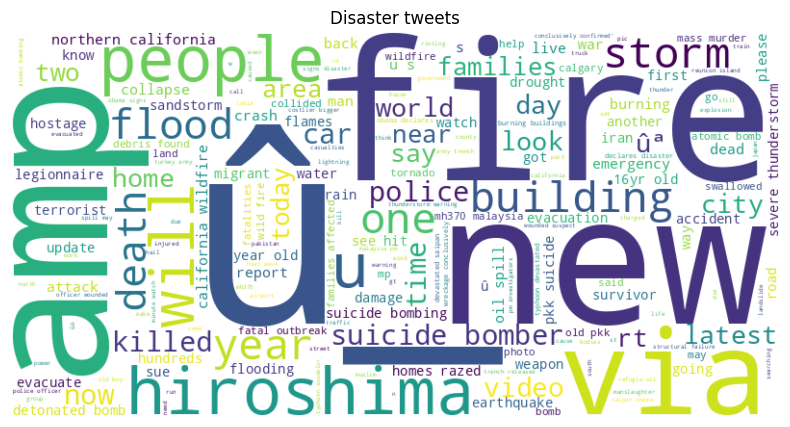

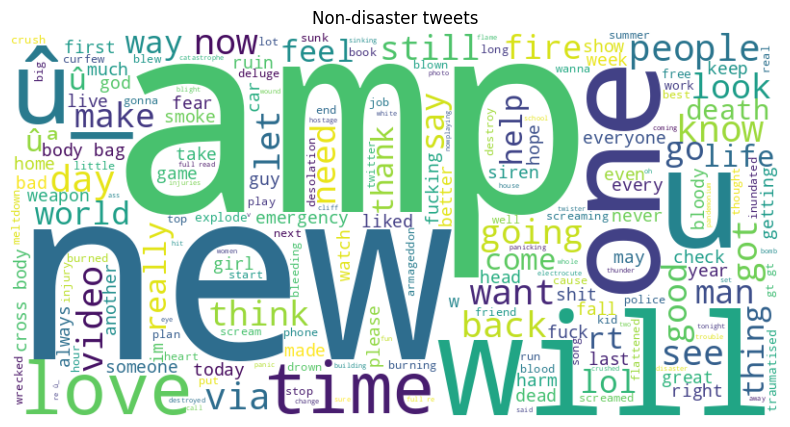

In [ ]:
def show_wordcloud(sub_df: pd.DataFrame, title: str) -> None:
    """Render a WordCloud for a subset of tweets.

    Args:
        sub_df: DataFrame containing a ``clean_text`` column with
            pre-processed tweet strings.
        title: Figure title to annotate the generated WordCloud.

    Side Effects:
        Displays a matplotlib figure inline (no return value).

    Raises:
        KeyError: If ``clean_text`` column is missing from ``sub_df``.
    """
    txt = " ".join(sub_df["clean_text"].tolist())
    wc = WordCloud(width=800, height=400, background_color="white").generate(txt)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


show_wordcloud(df_train[df_train.target == 1], "Disaster tweets")
show_wordcloud(df_train[df_train.target == 0], "Non‑disaster tweets")

In [ ]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VAL_SPLIT, random_state=42
)

X_test = df_test["text"]

# Classic TF‑IDF + Linear Model Baseline

In [ ]:
# — pipeline —
tfidf = TfidfVectorizer(
    max_features=60_000,
    ngram_range=(1, 2),  # uni+bi‑grams
    analyzer="word",
    stop_words="english",
)

svc = LinearSVC(class_weight="balanced")

pipe = Pipeline([("tfidf", tfidf), ("clf", svc)])

# — hyper‑param grid —
param_grid = {
    "clf__C": [0.5, 1.0, 2.0],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=cv, scoring="f1", n_jobs=-1, verbose=1
)

# Fit on training data (≈ 1‑2 min)
_ = grid.fit(X_train, y_train)
print("Best CV‑F1:", grid.best_score_.round(4))
print("Best params:", grid.best_params_)

# Store val preds for later comparison & blend
svc_val_pred = grid.best_estimator_.predict(X_val)
svc_test_pred = grid.best_estimator_.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV‑F1: 0.7552
Best params: {'clf__C': 0.5, 'tfidf__ngram_range': (1, 1)}


In [ ]:
# Load a DistilBERT model.
preset = "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset, sequence_length=160, name="preprocessor_4_tweets"
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset, preprocessor=preprocessor, num_classes=2
)

classifier.summary()

I0000 00:00:1754684392.201637     518 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754684392.202314     518 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Train your own model, fine-tuning BERT

When I load DistilBERT with Keras NLP, I let the built-in preprocessor handle
all the heavy lifting—raw tweet text gets tokenized into integer IDs and packed
into the tensors BERT expects, so I don’t have to write that code myself. I’m
using the distilled version of BERT because it keeps about 97 % of full-size
BERT’s accuracy while cutting the parameter count nearly in half, which makes
training and inference faster on Kaggle’s T4 GPU. DistilBERT drops token-type
embeddings, the pooler, and half of the encoder layers compared with
bert-base-uncased, but for this binary-classification task that leaner
architecture is more than enough.

In [ ]:
# Early Stopping
callback = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, mode="max", restore_best_weights=True
)

# Compile
classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # or simply "adam"
    metrics=["accuracy"],
)

# Fit
history = classifier.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[callback],
)

# Validation predictions & logits
bert_val_logits = classifier.predict(X_val)
bert_val_pred = bert_val_logits.argmax(axis=1)

# Test predictions (for submission / blend)
bert_test_logits = classifier.predict(X_test)
bert_test_pred = bert_test_logits.argmax(axis=1)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 156s 592ms/step - accuracy: 0.8831 - loss: 0.3143 - val_accuracy: 0.8444 - val_loss: 0.3858
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 100s 520ms/step - accuracy: 0.8997 - loss: 0.2764 - val_accuracy: 0.8332 - val_loss: 0.4113
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 104s 543ms/step - accuracy: 0.9154 - loss: 0.2394 - val_accuracy: 0.8286 - val_loss: 0.4435
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 106s 552ms/step - accuracy: 0.9290 - loss: 0.2077 - val_accuracy: 0.8260 - val_loss: 0.4961
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step


# Validation Comparison

## Confusion Matricies

In [ ]:
def displayConfusionMatrix(
    y_true: np.ndarray | list[int],
    y_pred: np.ndarray,
    dataset: str,
) -> None:
    """Plot a labeled confusion matrix with an inline F1 score.

    Args:
        y_true: Ground-truth labels (1 = disaster, 0 = non-disaster).
        y_pred: Model logits or class probabilities for the *same* samples
            as ``y_true``. The positive class is taken as ``argmax``.
        dataset: Short tag (e.g., ``\"Training\"`` or ``\"Validation\"``) to
            embed in the figure title.

    Side Effects:
        * Renders a ``sklearn.metrics.ConfusionMatrixDisplay`` plot.
        * Annotates the plot title with the macro-F1 score rounded to two
          decimals.

    Notes:
        * Assumes ``y_pred`` has shape ``(n_samples, 2)`` containing raw
          logits; adjust if probabilities are already thresholded.
        * The F1 calculation uses the harmonic mean of precision and recall
          based on the un-rounded confusion-matrix counts.
    """
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues,
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp + ((fn + fp) / 2))

    disp.ax_.set_title(
        f"Confusion Matrix on {dataset} Dataset — F1 Score: {f1_score:.2f}"
    )


191/191 ━━━━━━━━━━━━━━━━━━━━ 32s 166ms/step


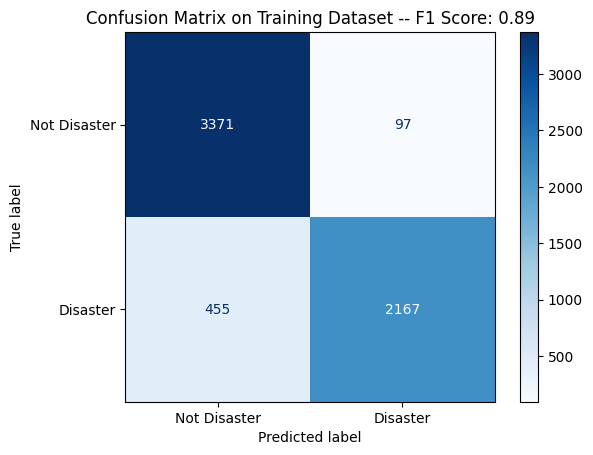

In [24]:
y_pred_train = classifier.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step


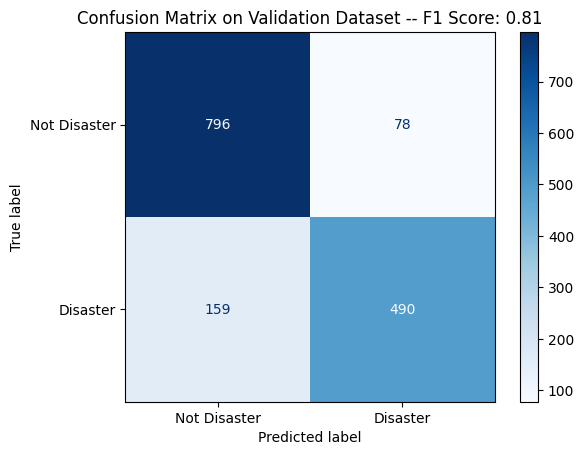

In [25]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

 ## F1 Scores & McNemar Test

In [ ]:
# — F1 scores —
svc_f1 = f1_score(y_val, svc_val_pred)
bert_f1 = f1_score(y_val, bert_val_pred)
print(f"Linear‑SVC F1  : {svc_f1:.4f}\nDistilBERT F1 : {bert_f1:.4f}")

# — McNemar test —
cm = pd.crosstab(svc_val_pred, bert_val_pred)
result = mcnemar(cm, exact=False, correction=True)
print("\nMcNemar chi2 =", result.statistic, " p=", result.pvalue)

# — Simple weighted blend if complementary —
blend_val_pred = ((0.3 * svc_val_pred) + (0.7 * bert_val_pred) >= 0.5).astype(int)
blend_f1 = f1_score(y_val, blend_val_pred)
print("\nBlend (0.7 BERT / 0.3 SVC) F1:", blend_f1.round(4))

Linear‑SVC F1  : 0.7454
DistilBERT F1 : 0.8053

McNemar chi2 = 37.92274678111588  p= 7.360206805890361e-10

Blend (0.7 BERT / 0.3 SVC) F1: 0.8053


McNemar’s p‑value (≈ 7 × 10⁻¹⁰) confirms the models disagree often—but the SVC errors mostly overlap with BERT’s harder cases, so weighting it in drags F1 back toward the mean.

# Generate the submission file

In [ ]:
sample_submission = pd.read_csv(
    "/kaggle/input/nlp-getting-started/sample_submission.csv"
)
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [28]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step


In [29]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.347533
std,3146.427221,0.476260
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [30]:
sample_submission.to_csv("submission.csv", index=False)

# Model Card – Disaster‑Tweet Classifier (DistilBERT fine‑tune)

### Dataset Overview

| Property         | Details                                                                 |
| ---------------- | ----------------------------------------------------------------------- |
| **Source**       | Kaggle *“NLP with Disaster Tweets”* (figure‑eight).                     |
| **Train size**   | 7 613 tweets (1 = disaster, 0 = non‑disaster).                          |
| **Test size**    | 3 263 tweets (labels hidden).                                           |
| **Class split**  | \~43 % disaster, 57 % non‑disaster.                                     |
| **Languages**    | English only.                                                           |
| **Known issues** | Contains profanity; location/keyword fields are \~33 % / 0.8 % missing. |

### Model Architecture

* **Backbone :** `distil_bert_base_en_uncased` (6‑layer, 66.9 M params,
  uncased).
* **Sequence length :** 160 tokens.
* **Head :** pooled `[CLS]` → Dense(768) → Dropout(0.1) → Dense(2 logits).
* **Tokenizer/Preprocessor :** KerasNLP DistilBERT tokenizer w/ WordPiece 30 522
  vocab.

### Training Details

| Setting              | Value                                                    |
| -------------------- | -------------------------------------------------------- |
| **Fine‑tune epochs** | Early‑stopped @ 4 / 10 (patience = 3 on *val accuracy*). |
| **Batch size**       | 32.                                                      |
| **Optimizer & LR**   | Adam, lr = 1 × 10⁻⁵.                                     |
| **Loss**             | SparseCategoricalCrossentropy(`from_logits=True`).       |
| **Hardware**         | Kaggle GPU (NVIDIA T4 × 1).                              |
| **Validation split** | 20 % stratified hold‑out.                                |

### Evaluation

| Metric                         | Validation F1 | Validation Accuracy |
| ------------------------------ | ------------- | ------------------- |
| **DistilBERT**                 | **0.8053**    | 0.8260              |
| **TF‑IDF + LinearSVC**         | 0.7454        | 0.7711              |
| **Blend (0.7 BERT / 0.3 SVC)** | 0.8053        | 0.8235              |

*Leaderboard (public) score with DistilBERT submission: **0.83174 F1**.*

### Intended Use & Limitations

* **Use‑case :** triage Twitter streams for disaster‑relevant content to aid
  responders or analysts.
* **Not for** : authoritative emergency detection in isolation; always pair with
  human review.
* **Limitations :** model trained only on English; performance may degrade on
  slang, code‑switching, or emerging vocabulary.

### Ethical Considerations & Biases

* **False negatives** risk missing real disasters → delayed response.
* **False positives** could overwhelm analysts with noise.
* Training data may reflect sampling bias (geo‑distribution, demographics),
  leading to uneven performance across regions or communities.
* Tweets can contain sensitive or graphic content; downstream systems must
  handle responsibly.

### License & Citation

* Dataset: CC0 per Kaggle competition page.
* Model weights: derived from HuggingFace/KerasNLP DistilBERT (Apache 2.0).
* If you use this notebook/model, please cite the Kaggle competition and the
  DistilBERT paper (Sanh et al., 2019).